In [1]:
# from experiments.sparse_spose_recon import compute_similarity_matrix
from models.admm import ADMM
from pathlib import Path
import numpy as np
from utils.plotting import plot_images_from_embedding
from utils.io import load_things_image_data
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tools.rsa import correlate_rsms, compute_similarity


def plot_rsm_side_by_side(s, s_hat):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(s, ax=axs[0], cmap="viridis", cbar_kws={"label": "Similarity"})
    axs[0].set_title("True RSM")

    sns.heatmap(
        s_hat,
        ax=axs[1],
        cmap="viridis",
        cbar_kws={"label": "Similarity"},
    )
    fig.suptitle(f"r = {correlate_rsms(s, s_hat):.2f}")

    plt.tight_layout()
    plt.show()
    return fig


/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
triplets = np.loadtxt(
    "/LOCAL/fmahner/model-comparisons/data/human_triplets/trainset.txt"
).astype(int)
sim, mask = compute_similarity_matrix(1854, triplets)

w = ADMM(
    rank=49,
    max_outer=50,
    max_inner=5,
    tol=0.0,
    verbose=True,
    rho=1.0,
    mask=mask,
).fit_transform(sim)


Iteration 1/50, Objective: 149786.063936, Rec Error: 430.251876, Evar: 0.452374
Iteration 2/50, Objective: 97803.038177, Rec Error: 341.400937, Evar: 0.565464
Iteration 3/50, Objective: 89036.245397, Rec Error: 314.126111, Evar: 0.600179
Iteration 4/50, Objective: 89049.207735, Rec Error: 306.321658, Evar: 0.610113
Iteration 5/50, Objective: 90084.584341, Rec Error: 303.881571, Evar: 0.613218
Iteration 6/50, Objective: 90753.136395, Rec Error: 302.923419, Evar: 0.614438
Iteration 7/50, Objective: 91054.266809, Rec Error: 302.415486, Evar: 0.615084
Iteration 8/50, Objective: 91136.890663, Rec Error: 302.070596, Evar: 0.615523
Iteration 9/50, Objective: 91107.822605, Rec Error: 301.808762, Evar: 0.615857
Iteration 10/50, Objective: 91034.232869, Rec Error: 301.601098, Evar: 0.616121
Iteration 11/50, Objective: 90947.924542, Rec Error: 301.436514, Evar: 0.616331
Iteration 12/50, Objective: 90865.251132, Rec Error: 301.307131, Evar: 0.616495
Iteration 13/50, Objective: 90793.798966, Rec Er

### HERE We Quickly Plot the Images from SPoSE and potentially other embeddings

In [ ]:
from utils.io import load_things_image_data
from utils.plotting import plot_images_from_embedding

images = load_things_image_data("/SSD/datasets/things", filter_behavior=True)
# sort w by sum of cols
w_sorted = w[:, np.argsort(w.sum(0))]
fig = plot_images_from_embedding(w_sorted, images, top_k=12, dpi=150)


In [ ]:
images = pd.read_csv("/SSD/projects/deepsim/raw/features/image_info.csv")


In [4]:
from models.admm import ADMM
from utils.plotting import plot_images_from_embedding
from datasets import load_dataset
from tools.rsa import compute_similarity
from tools.metrics import median_sigma_heuristic
from utils.helpers import rbf_entropy_heuristic
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

dnns = load_dataset("dnn", behavior=True)
x = dnns.data["ViT-L-14.laion2b_s32b_b82k.dataset"]

rsm = compute_similarity(x, x, "gaussian_kernel")


In [ ]:
model = ADMM(rank=30, max_outer=100, max_inner=10, tol=0.0, verbose=True, rho=1.0)
w = model.fit_transform(rsm)


In [ ]:
fig = plot_images_from_embedding(w, dnns.image_paths, top_k=12, dpi=150)


In [5]:
from cross_validation import cross_val_score


scorer = cross_val_score(
    rsm,
    param_grid={"rank": np.arange(10, 110, 10), "max_outer": [200], "max_inner": [20]},
    n_repeats=5,
    observed_fraction=0.3,
    fit_final_estimator=True,
)
cv_results = scorer.cv_results_


Running 50 jobs (10 params x 5 CV splits)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.


KeyboardInterrupt: 

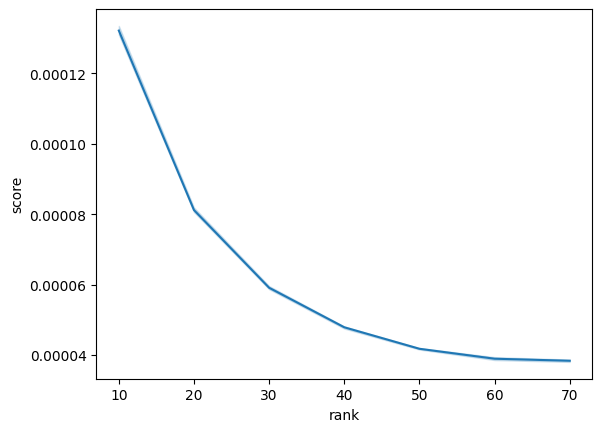

In [ ]:
import seaborn as sns

sns.lineplot(x="rank", y="score", data=scorer.cv_results_)
plt.show()


In [ ]:
best_estimator = scorer.best_estimator_
w = best_estimator.transform()


plot_images_from_embedding(w, images, top_k=12, dpi=150)


In [4]:
dnns = load_dataset("dnn", behavior=False)
x = dnns.data["vgg16_bn.IMAGENET1K_V1.architecture"]
rsm = compute_similarity(x, x, "gaussian_kernel")
model = ADMM(rank=60, max_outer=50, max_inner=20, tol=0.0, verbose=True, rho=1.0)
w = model.fit_transform(rsm)


In [ ]:
fig = plot_images_from_embedding(w, dnns.image_paths, top_k=10, dpi=150)


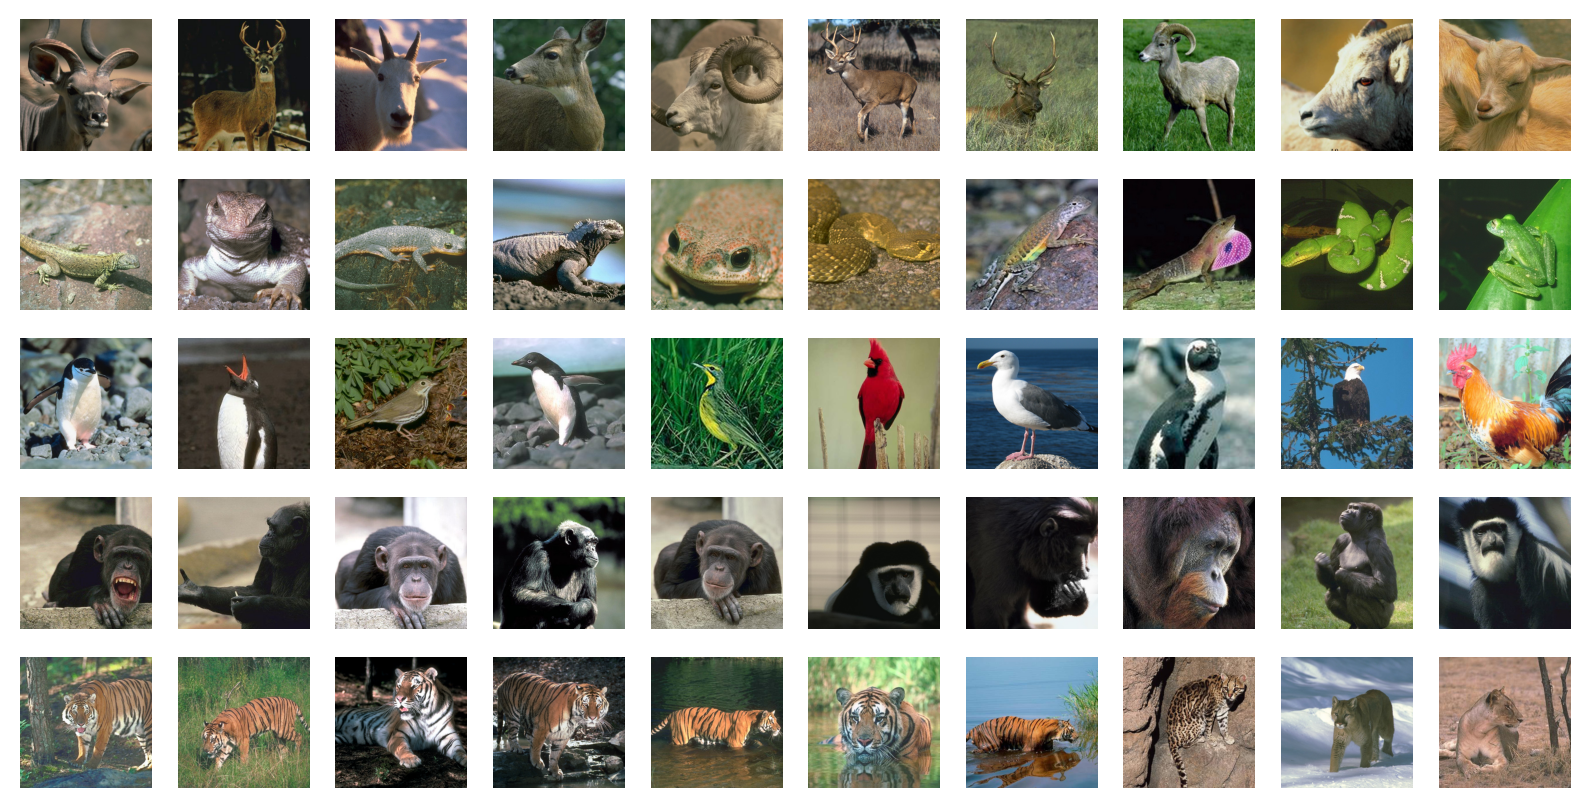

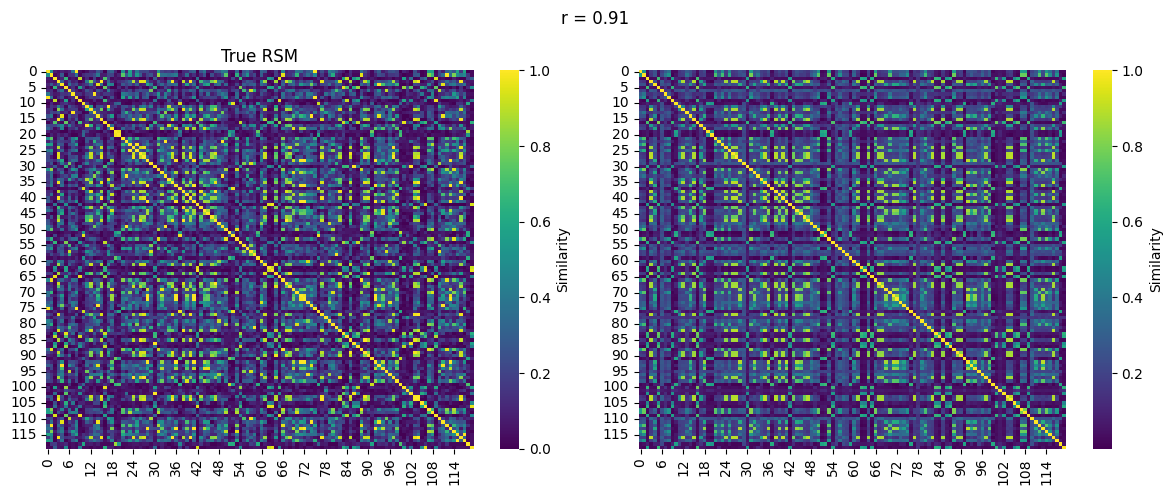

In [10]:
dataset = load_dataset("peterson-animals")
rsm = dataset.rsm

images = dataset.images

rank = 5
model = ADMM(
    rank=rank,
    tol=0.0,
)

w = model.fit_transform(rsm)

fig = plot_images_from_embedding(w, images, top_k=10, dpi=200)

s_hat = model.reconstruct()
np.fill_diagonal(s_hat, 1)
fig = plot_rsm_side_by_side(rsm, s_hat)
plt.show()


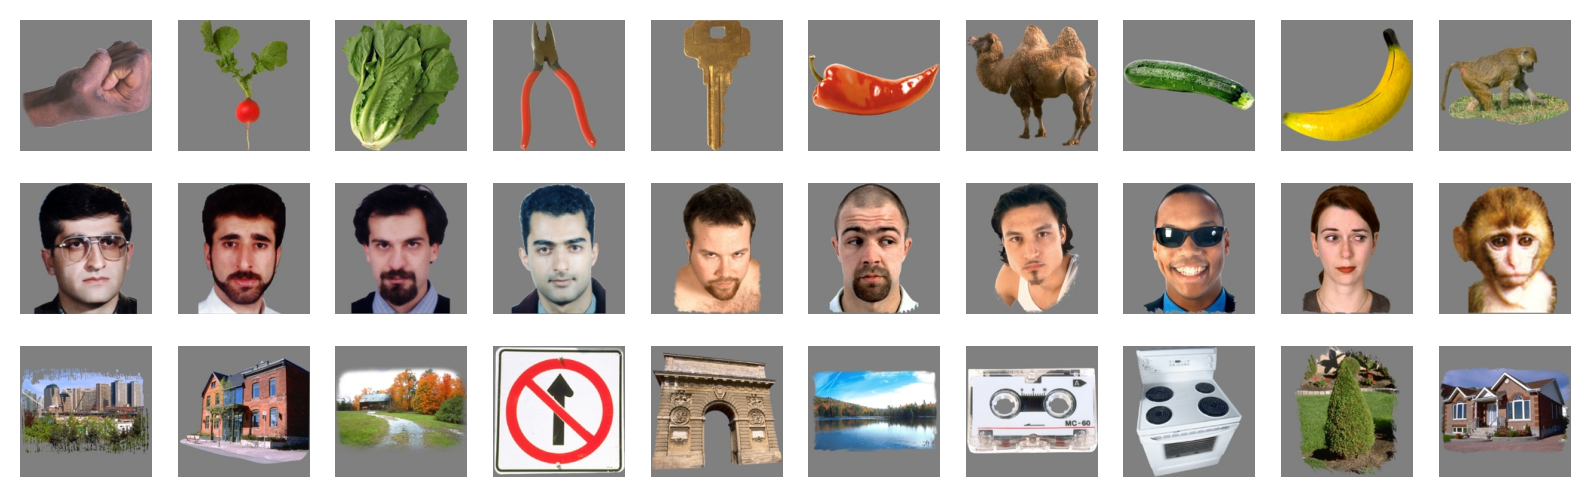

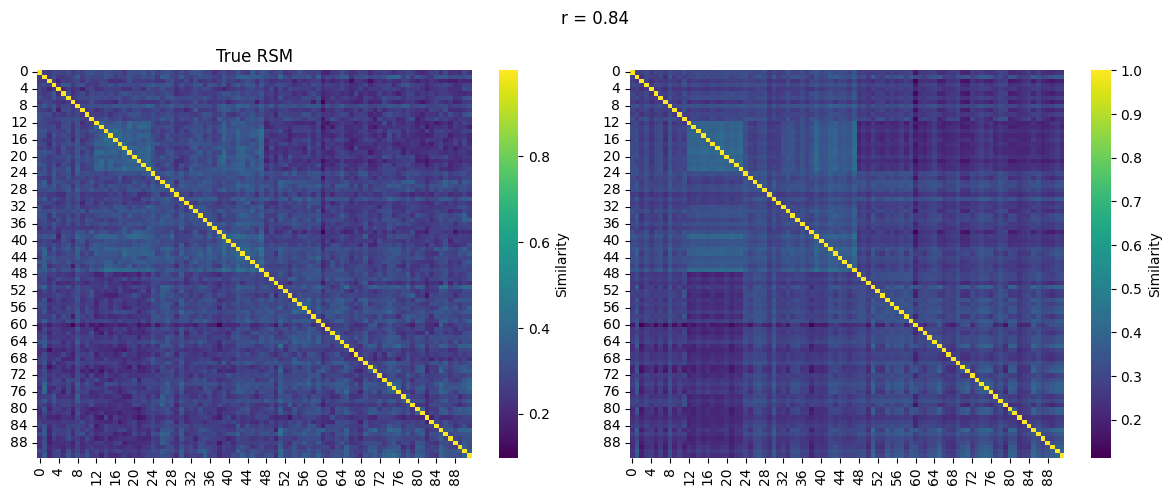

In [8]:
dataset = load_dataset("mur92")
rsm = dataset.group_rsm

images = dataset.images

rank = 3
model = ADMM(
    rank=rank,
)

w = model.fit_transform(rsm)

fig = plot_images_from_embedding(w, images, top_k=10, dpi=200)

s_hat = model.reconstruct()
np.fill_diagonal(s_hat, 1)
fig = plot_rsm_side_by_side(rsm, s_hat)
plt.show()


In [ ]:
monkey = load_dataset("things-monkey-22k", min_reliab=0.4)
rsm = monkey.rsm

it_data = monkey.it

print(it_data.shape)


(22248, 157)


In [ ]:
monkey = load_dataset("things-monkey-22k", min_reliab=0.2)
rsm = monkey.rsm

it_data = monkey.it

print(it_data.shape)

rsm = compute_similarity(it_data, it_data, "gaussian_kernel")

plt.hist(rsm.flatten(), bins=100)


In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset


monkey = load_dataset("things-monkey-22k", min_reliab=0.2)

w = np.load("../monkey_w_cosine_pos.npy")

filenames = monkey.filenames

image_info = pd.read_csv("../data/misc/image_info.csv")

image_paths = image_info[image_info["filename"].isin(filenames)]["path"].values


fig = plot_images_from_embedding(w, image_paths, top_k=10, dpi=150)


In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from utils.plotting import plot_images_from_embedding

monkey = load_dataset("things-monkey-22k", min_reliab=0.2)

w = np.load("../monkey_w_gaussian_zscored.npy")

filenames = monkey.filenames

image_info = pd.read_csv("../data/misc/image_info.csv")
image_paths = image_info[image_info["filename"].isin(filenames)]["path"].values

fig = plot_images_from_embedding(w, image_paths, top_k=10, dpi=150)
